In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
historical_df = pd.read_csv("historical_data.csv")
sentiment_df = pd.read_csv("fear_greed_index.csv")

In [65]:
print(historical_df.shape)
print(sentiment_df.shape)

(211224, 16)
(2644, 4)


In [66]:
print(historical_df.duplicated().sum())
print(sentiment_df.duplicated().sum())

0
0


In [67]:
print(historical_df.isnull().sum())

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


In [68]:
print(sentiment_df.isnull().sum())

timestamp         0
value             0
classification    0
date              0
dtype: int64


In [69]:
historical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [70]:
historical_df.iloc[0]

Account                    0xae5eacaf9c6b9111fd53034a602c192a04e082ed
Coin                                                             @107
Execution Price                                                7.9769
Size Tokens                                                    986.87
Size USD                                                      7872.16
Side                                                              BUY
Timestamp IST                                        02-12-2024 22:50
Start Position                                                    0.0
Direction                                                         Buy
Closed PnL                                                        0.0
Transaction Hash    0xec09451986a1874e3a980418412fcd0201f500c95bac...
Order ID                                                  52017706630
Crossed                                                          True
Fee                                                          0.345404
Trade ID            

In [71]:
historical_df.groupby(['Side', 'Direction']).size().reset_index()

,Side,Direction,0
0,BUY,Buy,16716
1,BUY,Close Short,36013
2,BUY,Liquidated Isolated Short,1
3,BUY,Open Long,49895
4,BUY,Settlement,1
5,BUY,Short > Long,70
6,SELL,Auto-Deleveraging,8
7,SELL,Close Long,48678
8,SELL,Long > Short,57
9,SELL,Open Short,39741


In [72]:
historical_df['Timestamp'].unique()

array([1.73e+12, 1.74e+12, 1.75e+12, 1.71e+12, 1.72e+12, 1.70e+12,
       1.68e+12])

In [73]:
historical_df['Timestamp IST'] = pd.to_datetime(historical_df['Timestamp IST'], dayfirst=True)

In [74]:
historical_df['date'] = historical_df['Timestamp IST'].dt.date.astype(str)

In [75]:
historical_df['date']

0         2024-12-02
1         2024-12-02
2         2024-12-02
3         2024-12-02
4         2024-12-02
             ...    
211219    2025-04-25
211220    2025-04-25
211221    2025-04-25
211222    2025-04-25
211223    2025-04-25
Name: date, Length: 211224, dtype: object

In [76]:
sentiment_df.iloc[0]

timestamp         1517463000
value                     30
classification          Fear
date              2018-02-01
Name: 0, dtype: object

In [77]:
sentiment_df.groupby('classification').agg({
    'value' : ['min', 'max']
})

value    
                 min max
classification          
Extreme Fear       5  24
Extreme Greed     75  95
Fear              25  44
Greed             55  74
Neutral           45  54

In [78]:
merged_df = historical_df.merge(sentiment_df[['date', 'value', 'classification']], on='date', how='left')

In [79]:
# Finding Average PnL across Sentiment Bins

In [80]:
merged_df.groupby('classification')['Closed PnL'].agg(['mean', 'std', 'count'])

,mean,std,count
classification,,,
Extreme Fear,34.537862,1136.056091,21400
Extreme Greed,67.892861,766.828294,39992
Fear,54.290400,935.355438,61837
Greed,42.743559,1116.028390,50303
Neutral,34.307718,517.122220,37686


### Insights
- Extreme Greed yields the highest average PnL with lower volatility than Fear/Greed → traders may use higher leverage or momentum strategies.
- Extreme Fear results in low average PnL and high volatility → indicating panic, irrational trades, or stop-losses being hit.
- Fear surprisingly performs better than Greed, suggesting cautious traders outperform overconfident ones during moderate dips.
- Neutral markets result in flat returns, as expected, due to low directional bias and fewer high-conviction trades.

In [81]:
# Volume Trends During Sentiment Extremes

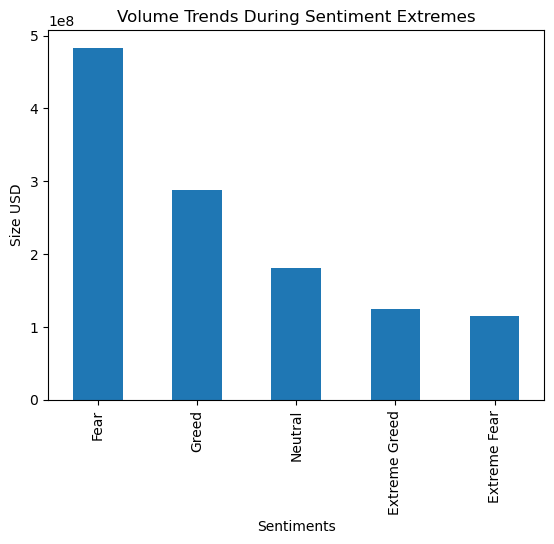

In [109]:
merged_df.groupby('classification')['Size USD'].sum().sort_values(ascending=False).plot(kind='bar')
plt.xlabel("Sentiments")
plt.ylabel("Size USD")
plt.title("Volume Trends During Sentiment Extremes")
plt.show()

### Insights
- The most trading activity happens during Fear, suggesting that traders are actively trying to buy the dip or hedge risk.
- Despite Extreme Greed yielding the highest PnL, it has relatively lower volume, possibly because:
    - Fewer traders take positions
    - Those who do may use high leverage or larger individual positions
- Extreme Fear shows low volume and low PnL, consistent with market paralysis — traders are risk-averse or sidelined.

In [83]:
# Correlation Between Sentiment Value and Avg PnL (Daily)

In [84]:
daily_avg = merged_df.groupby('date').agg({
    'Closed PnL': 'mean',
    'value': 'first'
})
daily_avg.corr()

,Closed PnL,value
Closed PnL,1.000000,0.037315
value,0.037315,1.000000


### Insights
- There is almost no linear correlation between the raw Fear-Greed value and average daily PnL.
- This means daily sentiment value alone doesn’t predict average trade outcome linearly.
- Other patterns (nonlinear, extreme thresholds, etc.) may matter more.

In [85]:
# Leverage (Position Size / PnL Ratio) Behavior by Sentiment

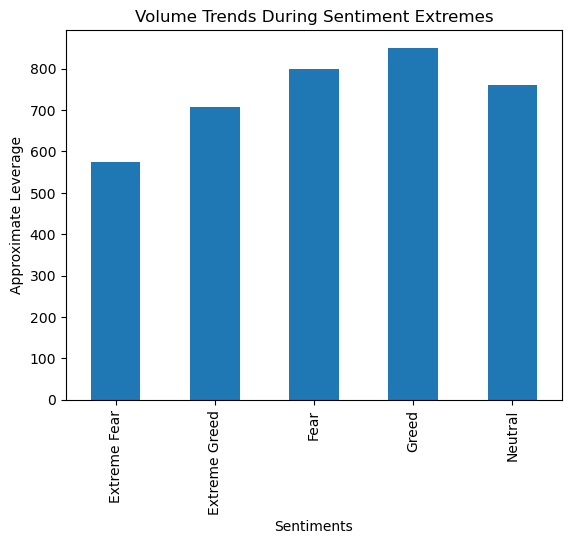

In [110]:
merged_df['approx_leverage'] = merged_df['Size USD'] / (np.abs(merged_df['Start Position']) + 1)
merged_df.groupby('classification')['approx_leverage'].mean().plot(kind = 'bar')
plt.xlabel("Sentiments")
plt.ylabel("Approximate Leverage")
plt.title("Volume Trends During Sentiment Extremes")
plt.show()

### Insights
- Traders use more leverage during moderate Greed than during Extreme Greed. This could suggest:
    - They book profits when the market is too hot (extreme greed)
    - Or get margin-called/liquidated before reaching those levels
- During Extreme Fear, leverage drops significantly:
    - Consistent with risk aversion, defensive trading, or capital constraints

In [87]:
# PnL of Crossed (Market) vs Passive Orders During Sentiment Bins

In [88]:
merged_df.groupby(['classification', 'Crossed'])['Closed PnL'].mean().unstack()

Crossed,False,True
classification,,
Extreme Fear,37.454281,32.310346
Extreme Greed,87.521185,55.975777
Fear,80.838937,36.656632
Greed,84.984286,16.241638
Neutral,25.551028,39.702777


### Insights
- Limit orders outperform market orders in most sentiment conditions — showing disciplined entries yield better results.
- Market orders underperform in Greed — likely due to impulsive FOMO-driven trades.
- Fear and Extreme Greed favor limit orders — cautious or strategic execution pays off in volatile markets.
- Only in Neutral markets do market orders win — fast execution helps when price action is slow or flat

In [89]:
# Finding Trade Direction Count by Sentiment

In [90]:
merged_df.groupby(['classification', 'Direction']).size().unstack(fill_value=0)

Direction,Auto-Deleveraging,Buy,Close Long,Close Short,Liquidated Isolated Short,Long > Short,Open Long,Open Short,Sell,Settlement,Short > Long,Spot Dust Conversion
classification,,,,,,,,,,,,
Extreme Fear,0,807,6241,3117,0,5,7005,3174,1042,0,6,3
Extreme Greed,0,5132,7186,6497,0,7,6300,7663,7164,0,11,32
Fear,0,3207,17260,9221,0,14,17824,10887,3364,0,18,42
Greed,8,4685,7998,11322,1,16,8544,11664,5986,1,23,55
Neutral,0,2885,9993,5850,0,15,10222,6353,2346,0,12,10


### Insights
- Open Long trades dominate during Fear, showing traders attempt to "buy the dip" in uncertain markets.
- Open Short spikes during Extreme Greed, indicating increased bearish bets as traders anticipate a reversal.
- Close Short is high during Greed, suggesting profit booking on prior bearish positions.
- Buy trades rise sharply in Extreme Greed, reflecting strong momentum-chasing behavior.
- Short > Long switches are more frequent in Greed, hinting at quick sentiment shifts and volatility.

In [91]:
# Detect Behavioral Shift on Consecutive Days of Sentiment Shift

In [92]:
daily_sentiment = sentiment_df[['date', 'value']].copy()
daily_sentiment['value_diff'] = daily_sentiment['value'].diff()

# Merging with daily PnL
daily_pnl = merged_df.groupby('date')['Closed PnL'].mean().reset_index()
merged_shift = pd.merge(daily_sentiment, daily_pnl, on='date', how='inner')

merged_shift[['value_diff', 'Closed PnL']].corr()

,value_diff,Closed PnL
value_diff,1.000000,0.050878
Closed PnL,0.050878,1.000000


### Insights
- Daily sentiment shifts have almost no linear impact on PnL — traders may not react instantly or uniformly to changing fear/greed.
- Low correlation (0.05) suggests performance is more tied to sentiment extremes than to daily fluctuations.
- Traders likely rely more on sentiment level thresholds (e.g. "Extreme Greed") than incremental changes.
- Indicates sentiment change alone is a weak signal for short-term trading outcomes.

In [93]:
# Testing for lagged effects to check if changes in sentiment influence PnL the next day (or vice versa)

In [94]:
# Shift PnL by -1 to align today's sentiment with tomorrow's PnL
merged_shift['Next_Day_PnL'] = merged_shift['Closed PnL'].shift(-1)

# Correlation between today's sentiment change and tomorrow's PnL
merged_shift[['value_diff', 'Next_Day_PnL']].corr()

,value_diff,Next_Day_PnL
value_diff,1.000000,-0.014514
Next_Day_PnL,-0.014514,1.000000


### Insights
- Daily sentiment changes have no meaningful impact on next-day PnL (correlation ≈ -0.01), suggesting traders react immediately to sentiment shifts.
- This confirms that sentiment levels, not their day-to-day changes, matter more for performance.

In [95]:
# Strategy Simulation – Buy on Fear, Sell on Greed (Contrarian)

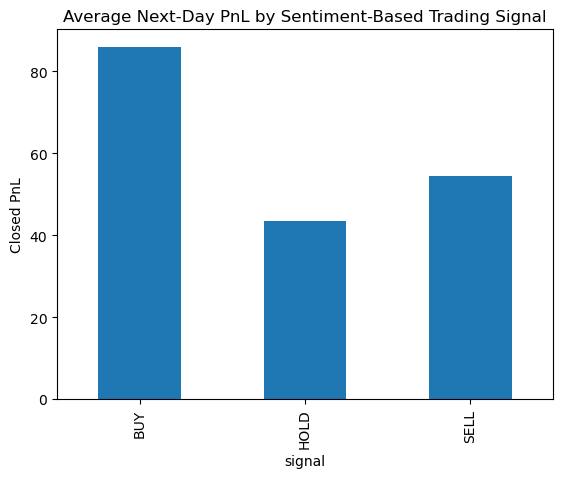

In [111]:
# Defining contrarian buy/sell signals
extreme_days = sentiment_df[['date', 'value']].copy()
extreme_days['signal'] = np.where(extreme_days['value'] <= 20, 'BUY', 
                           np.where(extreme_days['value'] >= 80, 'SELL', 'HOLD'))

# Shifting by 1 to simulate "next-day trading"
extreme_days['next_day'] = extreme_days['date'].shift(-1)

# Merging with next-day returns
next_day_pnl = merged_df.groupby('date')['Closed PnL'].mean().reset_index()
extreme_days = extreme_days.merge(next_day_pnl, left_on='next_day', right_on='date', how='left')

extreme_days.groupby('signal')['Closed PnL'].mean().plot(kind = 'bar')
plt.ylabel("Closed PnL")
plt.title("Average Next-Day PnL by Sentiment-Based Trading Signal")
plt.show()

### Insights
- Traders who buy in extreme fear (Fear ≤ 20) see the highest next-day profits, supporting contrarian strategies.
- Selling in extreme greed also performs decently, while neutral sentiment yields the weakest returns.

In [97]:
# Finding if PnL Differ by Sentiment by ANOVA?

In [98]:
from scipy.stats import f_oneway

groups = [group['Closed PnL'].values for name, group in merged_df.groupby('classification')]
f_stat, p_val = f_oneway(*groups)
print(f"F-statistic: {f_stat:.2f}, p-value: {p_val:.4f}")

F-statistic: 9.06, p-value: 0.0000


### Insights
- The p-value is well below 0.05, confirming that average PnL differs significantly across sentiment categories.
- This statistically validates that emotions like fear and greed impact trader outcomes.

In [99]:
# Checking if traders crowd into specific coins during “Extreme Fear.”

C:\Users\Administrator\AppData\Local\Temp\ipykernel_36852\3384970872.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




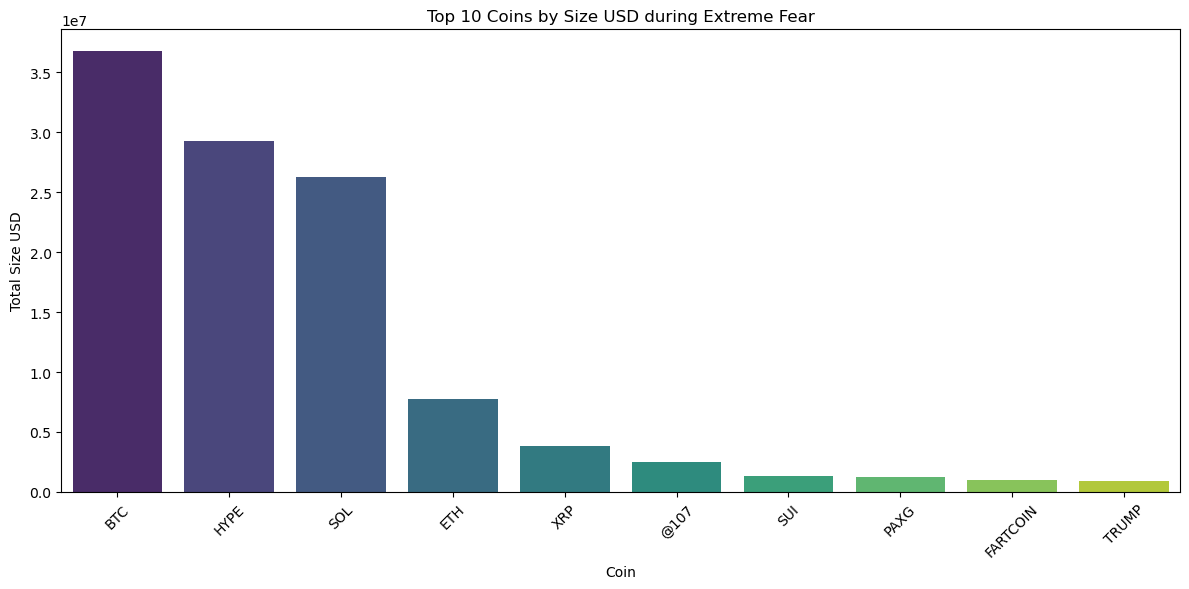

In [114]:
# Get the top 10 coins by 'Size USD' under 'Extreme Fear' classification
top_10 = merged_df[merged_df['classification'] == 'Extreme Fear'] \
            .groupby('Coin')['Size USD'] \
            .sum() \
            .sort_values(ascending=False) \
            .head(10)

# Reset index for plotting
top_10_df = top_10.reset_index()

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_df, x='Coin', y='Size USD', palette='viridis')

plt.title('Top 10 Coins by Size USD during Extreme Fear')
plt.xlabel('Coin')
plt.ylabel('Total Size USD')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Insights
- During Extreme Fear, traders poured the most capital into BTC, HYPE, and SOL — signaling strong belief in these assets even when the market panicked.
- Funny and risky coins like FARTCOIN and TRUMP still got big investments — nearly $1 million each — even when the market was scared.
-  Traders don’t run away during fear — they just shift their money into coins they feel strongly about.

In [101]:
# Checking account size influences performance by sentiment

In [102]:
merged_df['acct_size'] = merged_df.groupby('Account')['Size USD'].transform('sum')
merged_df['acct_bin'] = pd.qcut(merged_df['acct_size'], q=3, labels=['Small','Mid','Large'])
res = merged_df.groupby(['acct_bin','classification'])['Closed PnL'].mean().unstack()
res

C:\Users\Administrator\AppData\Local\Temp\ipykernel_36852\1273266317.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



classification,Extreme Fear,Extreme Greed,Fear,Greed,Neutral
acct_bin,,,,,
Small,15.318625,33.885413,29.695774,27.752566,18.755192
Mid,82.385746,188.971418,104.611287,84.002408,50.439233
Large,0.105386,64.739050,19.826461,37.806296,37.383026


### Insights
- Mid-sized traders made the highest profits across all sentiment levels, especially during Extreme Greed, where they far outperformed small and large traders.
- Large traders barely made any profit during Extreme Fear — possibly avoiding trades or being overly cautious.
- Small traders struggled during Greed, showing they may get caught in the hype and make poor timing decisions.

In [103]:
# how traders perform the day after market sentiment drops into Extreme Fear

In [104]:
sf = daily_sentiment.copy()
sf['prev_val'] = sf['value'].shift(1)
sf['deterioration'] = (sf['prev_val']>20) & (sf['value']<=20)
sp = sf[sf['deterioration']].merge(next_day_pnl, on='date', how='left')
sp['Closed PnL'].mean()

6.694658976473036

### Insights
- When sentiment drops into Extreme Fear, the next day’s profits are still positive (~6.7), suggesting panic dips create buying opportunities.
- Traders who act just after fear spikes can still make gains — fear-driven drops may be overreactions.